# HOW TO obtain data from ESO catalogues

The ESO catalogue facility provides access to the collection of data that were produced by PIs of ESO programmes and then integrated into the ESO science archive through the Phase 3 process. The full list of available cataolgues could be found [here](https://www.eso.org/qi/).

To access the data you can use the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) via the `tap_cat` TAP Service. `download_catalogues` is a simple python wrapper around this.

In [1]:
from ESOAsg.ancillary import astro
from ESOAsg.core import download_catalogues
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Choose the catalogue you want to query

To begin, you need to know which catalogue you are interested to query. If in doubt, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues using:
```python
download_catalogues.all_catalogues()
```
Note that the column `last_version` highlights with `False` if a newer version of the catalogue is present. It is possible to check this also programmatically, by [running the query](http://archive.eso.org/programmatic/#TAP?e=1&f=text&m=200&q=SELECT%0A%20%20%20%20t1.cat_id%2C%20t1.table_name%2C%20t1.title%2C%20t1.version%0AFROM%0A%20%20%20%20tables%20t1%0Aleft%20outer%20join%20tables%20t2%0Aon%20t1.title%20%3D%20t2.title%20and%20t1.version%20%3C%20t2.version%0AWHERE%0A%20%20%20%20t2.title%20is%20null%20AND%20t1.cat_id%20is%20not%20null&):
```SQL
SELECT
    t1.cat_id, t1.table_name, t1.title, t1.version
FROM
    tables t1
    left outer JOIN tables t2 ON (t1.title = t2.title AND t1.version < t2.version)
WHERE
    t2.title IS null AND t1.cat_id IS NOT null
```

In [3]:
all_catalogues = download_catalogues.all_catalogues()
all_catalogues.info()

<Table length=62>
     name      dtype                                        description                                      
-------------- ------ ---------------------------------------------------------------------------------------
    collection object                                   Name of the Phase 3 collection the catalog belongs to
    table_name object                                                          the fully qualified table name
         title object                                                                    Title of the catalog
   number_rows  int64                                   Number of rows present in this version of the catalog
       version  int32                                                                  version of the catalog
acknowledgment object It provides the sentence to be used in your publication when making use of this catalog
  last_version   bool                                       True if this is the latest version of the 

Now `all_catalogues` contains all catalogues (and all the versions) currently present at ESO:

In [4]:
all_catalogues['collection', 'table_name', 'title', 'version'].show_in_notebook(show_row_index=False, display_length=5)

collection,table_name,title,version
196.D-0214,EREBOS_RV_cat_fits_V1,EREBOS_RV_cat.fits,1
196.D-0214,EREBOS_cat_fits_V1,EREBOS_cat.fits,1
AMBRE,AMBRE_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra,1
ATLASGAL,ATLASGAL_V1,ATLASGAL - APEX Large Area Survey of the Galaxy,1
GAIAESO,GES_iDR4_PIII2016_Catalogue_v3_fits_V2,Gaia-ESO spectroscopic survey,2
GCAV,gcav_rxcj1515_YJKs_cat_fits_V1,GCAV catalogue for RXCJ1514.9-1523 cluster,1
GCAV,gcav_rxcj2129_YJKs_cat_fits_V1,GCAV catalogue for RXCJ2129.6+0005 cluster,1
GOODS_FORS2,GOODS_FORS2_V1,GOODS/FORS2 Spectroscopic Survey,1
GOODS_ISAAC,GOODS_ISAAC_V1,GOODS/ISAAC imaging,1
GOODS_VIMOS_SPEC,GOODS_VIMOS_SPEC_V1,GOODS/VIMOS Spectroscopic Survey,1


## Get a catalogue
In the following we will consider the [`VIKING`](https://www.eso.org/qi/catalog/show/320) catalogue as an example.
The acknowledgment for this is:

In [5]:
table_viking = 'viking_er4_zyjj_1j_2hks_catMetaData_fits_V3'
print(all_catalogues['acknowledgment'].data[all_catalogues['table_name'].data==table_viking])

[b'Please include the following acknowledgment in any published material that makes use of this data products: Based on observations made with ESO Telescopes at the La Silla or Paranal Observatories under programme ID(s) 179.A-2004(D)']


You can glance the content of a catalogue by checking the name of the columns present in the associated `table_name`:
```python
download_catalogues.columns_in_catalogue(table_name)
```

In [6]:
columns_viking = download_catalogues.columns_in_catalogue(table_viking)
columns_viking.show_in_notebook(show_row_index=False, display_length=10)

column_name,datatype,description,unit
IAUNAME,CHAR,IAU Name (not unique),
SOURCEID,BIGINT,UID of this merged detection as assigned by merge algorithm,
CUEVENTID,INTEGER,UID of curation event giving rise to this record,
FRAMESETID,BIGINT,UID of the set of frames that this merged source comes from,
RA2000,DOUBLE,Celestial Right Ascension,Degrees
DEC2000,DOUBLE,Celestial Declination,Degrees
L,DOUBLE,Galactic longitude,Degrees
B,DOUBLE,Galactic latitude,Degrees
LAMBDA,DOUBLE,SDSS system spherical co-ordinate 1,Degrees
ETA,DOUBLE,SDSS system spherical co-ordinate 2,Degrees


Once you decided which is your favourite catalogue, you can get it using:
```python
download_catalogues.query_catalogue(table_name)
```
At the moment with limit the query to only 5 entries `VIKING`:

In [7]:
VIKING = download_catalogues.query_catalogue(table_viking, maxrec=5)

[INFO]    :: The query is:
[INFO]    :: SELECT 
                    * 
               FROM 
                    viking_er4_zyjj_1j_2hks_catMetaData_fits_V3
            


The result is thus stored in an `astropy.table`:

In [8]:
VIKING.show_in_notebook(show_row_index=False, display_length=5)

AH,AJ,AKS,AY,AZ,B,CUEVENTID,DEC2000,EBV,ETA,FRAMESETID,HAPERMAG3,HAPERMAG3ERR,HAPERMAG4,HAPERMAG4ERR,HAPERMAG6,HAPERMAG6ERR,HAPERMAGNOAPERCORR3,HAPERMAGNOAPERCORR4,HAPERMAGNOAPERCORR6,HAVERAGECONF,HCLASS,HCLASSSTAT,HELL,HERRBITS,HETA,HGAUSIG,HHLCORSMJRADAS,HMJD,HMKSEXT,HMKSEXTERR,HMKSPNT,HMKSPNTERR,HPA,HPETROMAG,HPETROMAGERR,HPPERRBITS,HSEQNUM,HXI,IAUNAME,JAPERMAG3,JAPERMAG3ERR,JAPERMAG4,JAPERMAG4ERR,JAPERMAG6,JAPERMAG6ERR,JAPERMAGNOAPERCORR3,JAPERMAGNOAPERCORR4,JAPERMAGNOAPERCORR6,JAVERAGECONF,JCLASS,JCLASSSTAT,JELL,JERRBITS,JETA,JGAUSIG,JHLCORSMJRADAS,JMHEXT,JMHEXTERR,JMHPNT,JMHPNTERR,JMJD,JPA,JPETROMAG,JPETROMAGERR,JPPERRBITS,JSEQNUM,JXI,J_1APERMAG3,J_1APERMAG3ERR,J_1APERMAG4,J_1APERMAG4ERR,J_1APERMAG6,J_1APERMAG6ERR,J_1APERMAGNOAPERCORR3,J_1APERMAGNOAPERCORR4,J_1APERMAGNOAPERCORR6,J_1AVERAGECONF,J_1CLASS,J_1CLASSSTAT,J_1ELL,J_1ERRBITS,J_1ETA,J_1GAUSIG,J_1HLCORSMJRADAS,J_1MHEXT,J_1MHEXTERR,J_1MHPNT,J_1MHPNTERR,J_1MJD,J_1PA,J_1PETROMAG,J_1PETROMAGERR,J_1PPERRBITS,J_1SEQNUM,J_1XI,J_2APERMAG3,J_2APERMAG3ERR,J_2APERMAG4,J_2APERMAG4ERR,J_2APERMAG6,J_2APERMAG6ERR,J_2APERMAGNOAPERCORR3,J_2APERMAGNOAPERCORR4,J_2APERMAGNOAPERCORR6,J_2AVERAGECONF,J_2CLASS,J_2CLASSSTAT,J_2ELL,J_2ERRBITS,J_2ETA,J_2GAUSIG,J_2HLCORSMJRADAS,J_2MJD,J_2PA,J_2PETROMAG,J_2PETROMAGERR,J_2PPERRBITS,J_2SEQNUM,J_2XI,KSAPERMAG3,KSAPERMAG3ERR,KSAPERMAG4,KSAPERMAG4ERR,KSAPERMAG6,KSAPERMAG6ERR,KSAPERMAGNOAPERCORR3,KSAPERMAGNOAPERCORR4,KSAPERMAGNOAPERCORR6,KSAVERAGECONF,KSCLASS,KSCLASSSTAT,KSELL,KSERRBITS,KSETA,KSGAUSIG,KSHLCORSMJRADAS,KSMJD,KSPA,KSPETROMAG,KSPETROMAGERR,KSPPERRBITS,KSSEQNUM,KSXI,L,LAMBDA,MERGEDCLASS,MERGEDCLASSSTAT,PGALAXY,PNOISE,PRIMARY_SOURCE,PRIORSEC,PSATURATED,PSTAR,RA2000,SOURCEID,YAPERMAG3,YAPERMAG3ERR,YAPERMAG4,YAPERMAG4ERR,YAPERMAG6,YAPERMAG6ERR,YAPERMAGNOAPERCORR3,YAPERMAGNOAPERCORR4,YAPERMAGNOAPERCORR6,YAVERAGECONF,YCLASS,YCLASSSTAT,YELL,YERRBITS,YETA,YGAUSIG,YHLCORSMJRADAS,YMJD,YMJEXT,YMJEXTERR,YMJPNT,YMJPNTERR,YMJ_2EXT,YMJ_2EXTERR,YMJ_2PNT,YMJ_2PNTERR,YPA,YPETROMAG,YPETROMAGERR,YPPERRBITS,YSEQNUM,YXI,ZAPERMAG3,ZAPERMAG3ERR,ZAPERMAG4,ZAPERMAG4ERR,ZAPERMAG6,ZAPERMAG6ERR,ZAPERMAGNOAPERCORR3,ZAPERMAGNOAPERCORR4,ZAPERMAGNOAPERCORR6,ZAVERAGECONF,ZCLASS,ZCLASSSTAT,ZELL,ZERRBITS,ZETA,ZGAUSIG,ZHLCORSMJRADAS,ZMJD,ZMYEXT,ZMYEXTERR,ZMYPNT,ZMYPNTERR,ZPA,ZPETROMAG,ZPETROMAGERR,ZPPERRBITS,ZSEQNUM,ZXI
mag,mag,mag,mag,mag,Degrees,,Degrees,,Degrees,,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,arcsec,pixels,arcsec,days,mag,mag,mag,mag,Degrees,mag,mag,,,arcsec,,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,arcsec,pixels,arcsec,mag,mag,mag,mag,days,Degrees,mag,mag,,,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,arcsec,pixels,arcsec,mag,mag,mag,mag,days,Degrees,mag,mag,,,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,arcsec,pixels,arcsec,days,Degrees,mag,mag,,,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,arcsec,pixels,arcsec,days,Degrees,mag,mag,,,arcsec,Degrees,Degrees,,,,,,,,,Degrees,,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,arcsec,pixels,arcsec,days,mag,mag,mag,mag,mag,mag,mag,mag,Degrees,mag,mag,,,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,arcsec,pixels,arcsec,days,mag,mag,mag,mag,Degrees,mag,mag,,,arcsec
0.0076402617,0.011976626,0.005007469,0.01690666,0.022069,-76.81526040470847,514701,-33.411903703301526,0.012905847,-178.9627553197299,601295421942,19.867529,0.22879931,19.581171,0.2136419,19.515806,0.34939232,20.233175,19.774734,19.563423,102.640564,1,0.9395473,0.33763438,0,-0.10027519,1.1222153,1.0210307,55504.10656365289,1.0483685,0.2737869,1.0455112,0.2737869,37.98506,19.517645,0.27826083,--,505,0.14084883,viking J235740.10-332442.85,20.614698,0.16775802,20.55287,0.19086184,21.144445,0.5607424,21.026396,20.77074,21.185177,105.848404,1,2.0858436,0.23286873,0,-0.25635406,1.4156337,0.0,0.7932205,0.2837109,0.7471695,0.2837109,55467.69118156433,137.45097,21.366055,0.74475867,--,739,-0.032214742,20.42568,0.24046318,20.401106,0.28366846,21.265694,1.0700074,20.835754,20.619753,21.31014,102.84069,1,1.0449042,0.09908825,0,-0.1261886,0.81578517,0.24002537,0.60

## Explore the data

Now the `VIKING` catalogue is ready to be explored. As an example, we queried a larger fraction of the catalogue to show the color-color diagram for stars (in blue) and extended sources (red). Note that to speed up the process, we selected only the query the table for only the column we are interested in.

[INFO]    :: The query is:
[INFO]    :: SELECT 
                    MERGEDCLASS, ZAPERMAG3, JAPERMAG3, KSAPERMAG3 
               FROM 
                    viking_er4_zyjj_1j_2hks_catMetaData_fits_V3
            


<IPython.core.display.Javascript object>


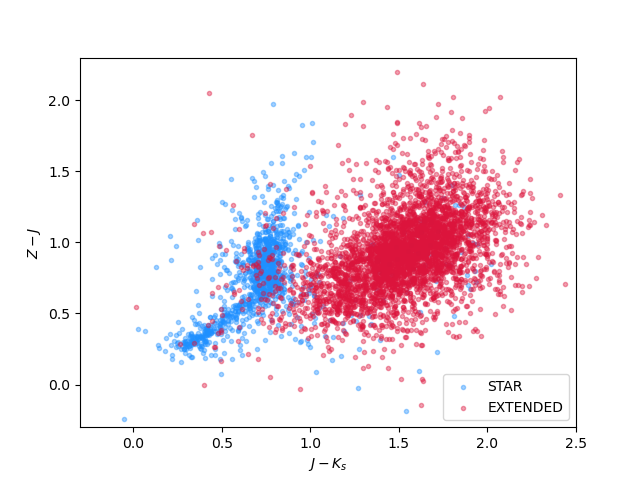

In [9]:
selected_columns = ['MERGEDCLASS', 'ZAPERMAG3', 'JAPERMAG3', 'KSAPERMAG3']

VIKING = download_catalogues.query_catalogue(table_viking, which_columns=selected_columns, maxrec=10000)

CLASS_STAR = VIKING['MERGEDCLASS'].data
JK = VIKING['JAPERMAG3'].data-VIKING['KSAPERMAG3'].data
ZJ = VIKING['ZAPERMAG3'].data-VIKING['JAPERMAG3'].data

plt.figure()
plt.xlim(-.3,2.5)
plt.ylim(-.3,2.3)
plt.scatter(JK[CLASS_STAR==-1],ZJ[CLASS_STAR==-1], label=r'STAR', c='dodgerblue', alpha=0.4, marker='.')
plt.scatter(JK[CLASS_STAR==1],ZJ[CLASS_STAR==1], label=r'EXTENDED', c='crimson', alpha=0.4, marker='.')
plt.xlabel(r'$J - K_s$')
plt.ylabel(r'$Z - J$')
plt.legend()
plt.show()
plt.savefig('viking.jpg', format='jpg', quality=99, bbox_inches='tight')